# CV QC simulations

In this notebook I will go over two simple examples of continuous variable quantum circuits: one that simulates the Hong-Ou-Mandel effect and one that prepares a special type of quantum state called a squeezed cat state. These circuits work with qumodes, which are essentially quantum harmonic oscillators, instead of qubits. 

We will do everything in terms of the Fock basis which allows us to simulate any quantum system albeit with exponential scaling in the number of qumodes. 

## Defining necessary CV quantum operations

### Quadratures

In CV QC we define two dimensionless operators called the quadrature field operators, $q$ and $p$, which are analogs of the position and momentum operators, $x$ and $p$ respectively and behave very similarly. 

### The Fock basis

First we implement a function, `fock_ket`, to create the kets corresponding to the Fock state $\ket{n}$ where $n \in \{0,1,2,3,...\}$. The Fock states are the energy eignestates of the quantum Harmonic oscillator. 

We will specify how the Fock states are represneted in most simulation tools like StrawberryFields and QuTiP. It is a simple extension of the definition of the computational basis states, $\ket{0}$ and $\ket{1}$, for qubits to higher dimensional systems. For the first 3 Fock states with a Hilbert space cutoff of $3$ (so the vectors are 3 dimensional) the states are given by the vector

$$
\ket{0} = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}, \ket{1} = \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}, \ket{2} = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}.
$$

The extension of this to higher cutoffs is straightforward e.g. for the first 4 Fock states with a cutoff of 4 we have

$$
\ket{0} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}, \ket{1} = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \ket{2} = \begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \end{bmatrix}, \ket{3} = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix}.
$$

The choice of the cutoff for the simulated Hilbert space is dependent on what you anticipate the energy of your system will be. For example in the Hong-Ou-Mandel example we show later our system consists of two qumodes each of which contain a single photon. Since we only apply unitaries (the beamsplitter) that are passive, i.e. unitaries that preserve the photon number (energy) of the system, it is sufficient to use a cutoff of $3$ because the highest energy Fock state we will be able to reach is the Fock state containing $2$ photons $\ket{2}$. 
However, if we were to use unitaries that are not passive like the squeezing unitary operation then the choice of cutoff becomes more tricky as the photon number of the system scales exponentially with the squeezing strength. 

### Squeezing

Next we define the squeezing operator $S(\zeta)$ which mathematically is given by

$$
S(\zeta) = e^{ \frac{1}{2}(\zeta^* aa - \zeta a^\dagger a^\dagger) }
$$

where $a$ and $a^\dagger$ are the annihilation and creation (ladder) operators for the qumode and $\zeta=re^{i\phi}$ is a complex number that defines the magnitude, $r$, and direction of the squeezing, $\phi$. This operation changes the *variance* of the quadrature operators, $(\Delta q)^2$ and $(\Delta p)^2$ respectively, of the qumode. Specifically, when $r > 0$ and is real the squeezing operation increases the variance of the momentum quadrature operator of the qumode. Note that since $[q,p]=i\hbar$ the operators $q$ and $p$ obey Heisenberg’s uncertainty principle $\Delta p \Delta q \geq \frac{\hbar}{2}$ so an increase in the variance of the momentum quadrature operator induces a decrease in the variance of the position quadrature operator.

Below we show two functions that compute the matrix representation of the squeezing operator in the Fock basis. `squeeze_matexp` computes the matrix by first creating the matrix representation of the ladder operators and computing the matrix exponential using `PyTorch` which is not exact. `squeeze_recursive` computes the matrix by filling out it's elements using the recurrence relation presented in the work [Fast optimization of parametrized quantum optical circuits](https://quantum-journal.org/papers/q-2020-11-30-366/) which gives the exact matrix elements.

### Beamsplitter

Next we define the beamsplitter operator $B(\theta,\phi)$ which is a two-qumode operator that produces entaglment between two modes. 
The beamsplitter can also be defined by two complex scalar parameters $\tau$ and $\rho$ which are the transmittivity and reflectivity of the beamsplitter and are related to $\theta$ and $\phi$ by the equations

$$
\tau = \cos\theta \\
\rho = e^{i\phi}\sin\theta
$$

and satsify the equation

$$
|\tau|^2 + |\rho|^2 = 1.
$$

Essentially the transmittivity determines how much of the light incident onto the beamplsitter is transmitted and the reflectivity determines how much is reflected.

The unitary is given by the expression

$$
B(\theta,\phi) = e^{ \theta(e^{i\phi} a_1 \otimes a_2^\dagger - e^{-i\phi} a_1^\dagger \otimes a_2 ) }
$$

where $a_1$ and $a_2$ are the annihilation operators for qumodes 1 and 2 respectively. Below we show two functions that compute the matrix representation of the beamsplitter operator in the Fock basis. `beamsplitter_recursive` computes the matrix by filling out it's elements using the recurrence relation presented in the work [Fast optimization of parametrized quantum optical circuits](https://quantum-journal.org/papers/q-2020-11-30-366/) which gives the exact matrix elements. 

Below we will define the Python functions to implement the qumode based operations we talked about above along with some helper functions to implement standard quantum operations like projective measurement that should be the same as in qubit based QC. 

In [1]:
import torch as th
from torch import Tensor, complex128, tensor
from math import sqrt, pi, cos, sin, acos, cosh, tanh
from cmath import exp, phase
from sympy import latex, Matrix
from qutip import plot_wigner, Qobj
from IPython.display import display, Math, Image

def sech(x):
    return 1 / cosh(x)


def fock_ket(dim, n):
    """
    Returns the ket of the Fock state
    |Ψ⟩ = |n⟩
    
    Args:
    dim: The Hilbert space truncation
    n: The Fock state number

    Returns
    Tensor: The ket vector of the Fock state |n⟩
    """

    psi = th.zeros((dim,), dtype=complex128)
    psi[n] = 1.0
    return psi


def squeeze_matexp(dim: int, zeta: complex):
    """
    A simple implementation of the squeezing unitary: S(ζ) = exp( 0.5(aaζ* - a†a†ζ) )
    where ζ = r*exp(iφ) is the complex squeezing parameter. This method is not the most optimal
    as it involves matrix exponentiation of finite dimensional matrix representations of 
    the infinite dimensional annihilation and creation operators.

    Args:
        dim: the Hilbert space cutoff
        zeta: The squeezing parameter

    Returns:
        Tensor: The unitary matrix representation of the squeezing operator S(ζ) in the Fock basis
                up to the cutoff dimension
    """
    diag = tensor([sqrt(n) for n in range(1, dim)], dtype=complex128)  # create diagonal
    a = th.diag(diag, 1)  # create matrix with diagonal shifted up by 1
    a_dag = th.diag(diag, -1)  # create matrix with diagonal shifted down by 1
    S = th.matrix_exp(0.5 * (zeta.conjugate() * a@a  -  zeta* a_dag@a_dag) )
    return S


def squeeze_recursive(dim: int, zeta: complex):
    """
    A recursive implementation of the squeezing unitary: S(ζ) = exp( 0.5(aaζ* - a†a†ζ) )
    where ζ = r*exp(iφ) is the complex squeezing parameter. Unlike the implementations
    based on matrix exponentiation of the ladder operators this approach 
    computes the exact matrix elements.
    Based on the work: https://quantum-journal.org/papers/q-2020-11-30-366/

    Args:
        dim: the Hilbert space cutoff
        zeta: The squeezing parameter

    Returns:
        Tensor: The unitary matrix representation of the squeezing operator S(ζ) in the Fock basis
                up to the cutoff dimension
    """

    S = th.zeros((dim, dim), dtype=complex128)

    zeta = zeta.conjugate()
    r = abs(zeta)
    phi = phase(zeta)

    S[0, 0] = sqrt(sech(r))  # see Equation 50 from the paper in doc string

    for m in range(dim - 1):
        # see Equation 51 from the paper in doc string
        S[m + 1, 0] = -sqrt(m / (m + 1)) * S[m - 1, 0] * exp(1j * phi) * tanh(r)

    for m in range(dim - 1):
        for n in range(dim - 1):
            # see Equation 52 from the paper in doc string
            S[m, n + 1] = (
                1/(sqrt(n + 1)) * (
                    sqrt(m) * S[m - 1, n] * (sech(r))
                    + sqrt(n) * S[m, n - 1] * exp(-1j * phi) * tanh(r)
                )
            )

    return S


def beamsplitter_recursive(dim: int, theta: float, phi: float):
    """
    A recursive implementation of the beamsplitter unitary:
    B(θ,φ) = exp( θ(exp(iφ)ab† - exp(-iφ)a†b) )
    where a is the annihilation operator of mode 1 and
    b annihilation operator of mode 2. Unlike the implementations
    based on matrix exponentiation of the ladder operators this approach 
    computes the exact matrix elements.
    Based on the work: https://quantum-journal.org/papers/q-2020-11-30-366/

    Args:
        dim: the Hilbert space cutoff
        theta: The transmittivity angle. The transmission amplitude
                       of the beamsplitter is t=cos(θ).
                       θ=pi/4 gives the 50/50 beamsplitter
        phi: The phase angle. The reflection amplitude
                     of the beamsplitter is r=exp(iφ)sin(θ)

    Returns:
        Tensor: The unitary matrix representation of the beamsplitter operator
        B(θ,φ) in the Fock basis up to the cutoff dimension
    """

    B =  th.zeros((dim,dim,dim,dim), dtype=complex128)
    V = tensor( [ [cos(theta), -exp(-1j*phi)*sin(theta)], 
                     [exp(1j*phi)*sin(theta), cos(theta)] ] )  # see Equation 60 from the paper in doc string
    
    B[0,0,0,0] = 1.0 # see Equation 73 from the paper in doc string

    for m in range(dim):
        for n in range(dim):
            if 0 < m+n < dim:
                # see Equation 74 from the paper in doc string
                B[m,n,m+n,0]  = 1 / sqrt(m+n) * ( sqrt(m)*V[0,0]*B[m-1,n,m+n-1,0] + sqrt(n)*V[1,0]*B[m,n-1,m+n-1,0] )


    for m in range(dim):
        for n in range(dim):
            for p in range(dim):
                if 0 < m+n-p < dim:
                    # see Equation 75 from the paper in doc string
                    B[m,n,p,m+n-p]  = 1 / sqrt(m+n-p) * ( sqrt(m)*V[0,1]*B[m-1,n,p,m+n-p-1] + sqrt(n)*V[1,1]*B[m,n-1,p,m+n-p-1] )


    return B.reshape(dim**2, dim**2)


def partial_trace(dim: int, S: Tensor, mode: int) -> Tensor:
    """
    Keeps qumode specified by 'mode' by tracing over other mode
    This is a PyTorch implementation of the numpy based partial trace
    presented in: https://www.peijun.me/reduced-density-matrix-and-partial-trace.html
    Needs to be generalized to more than two modes but is sufficient for the demonstrations 
    below.
    """
    n1 = n2 = dim
    S = S.reshape((n1, n2, n1, n2))

    if mode == 0:
        reduced_dm = th.diagonal(S, dim1=1, dim2=3).sum(-1)
    else:
        reduced_dm = th.diagonal(S, dim1=0, dim2=2).sum(-1)

    return reduced_dm


def measure_pnr(S: Tensor, projector: Tensor, identity: Tensor) -> Tensor:
    """
    Perform projective PNR measurement on mode 1 using the formula from Appendix A of:
    https://iopscience.iop.org/article/10.1088/1367-2630/ab5330/meta

    Args:
    S: The 2-qumode density matrix of the state 
    projector: The projector for the measurement
    identity: The identity matrix (operator)

    Returns:
    Tensor:
    The renormalized density matrix after the projector
    has been applied to it.
    """
    projector = th.kron(projector, identity)  # compute tensor product: P = P ⊗ I
    S = projector @ S  # apply projector: Pρ
    S = S / th.trace(S)  # normalize density matrix Pρ / Tr[Pρ]
    return S


def ket_2_dm(psi: Tensor):
    """
    Returns the density matrix representation of
    a ket state `psi`:
    ρ = |Ψ⟩⟨Ψ|

    Args:
    psi: The complex ket/vector |Ψ⟩

    Returns:
    Tesnor: The density matrix of the quantum state represented by psi
    """

    rho = th.outer(psi, th.conj(psi))
    return rho

Below we show two examples of performing quantum simulation/computation in CV QC in the Fock basis. First we simulate the famous [Hong-Ou-Mandel effect](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect) and for our second example we simulate a state preparation scheme discovered by a reinfrocment learning agent from the paper [Machine learning for efficient generation of universal photonic quantum computing resources](https://opg.optica.org/opticaq/fulltext.cfm?uri=opticaq-2-4-296&id=554736) for preparing a squeezed cat state.

## Example 1: Hong-Ou-Mandel effect

The Hong-Ou-Mandel effect can be observed when sending two identical photons through a 50-50 beamsplitter i.e. a beamsplitter whose reflectivity and transmitivity are equal. The resulting quantum state is entangled and one finds that *both* photons always end up in the same mode when measuring both modes with a photon number detector. 


To simulate this we will begin with a two qumode system written as

$$
\ket{\psi_{\text{in}}} = \ket{1}_1 \otimes \ket{1}_2 = \ket{1,1}
$$

where $\ket{1}_1$ denotes the state of qumode 1 and $\ket{1}_2$ denotes the state of qumode 2. Both qumodes are in the Fock state $\ket{1}$ indicating that there is one photon in each mode. 

$$
\begin{align*}
\ket{\psi_{\text{in}}} &= \ket{1}_1 \otimes \ket{1}_2 \\
&= \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix} \\
&= \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}
\end{align*}
$$

We then evolve the state by applying the beamsplitter unitary $B(\theta, \phi)$ with $\theta=\frac{\pi}{4}$, which gives the 50-50 beamsplitter, and $\phi=0$.

$$
\begin{align*}
\ket{\psi_{\text{out}}} &= B\left(\frac{\pi}{4},0\right) \ket{\psi_{\text{in}}} \\
&=  \frac{1}{\sqrt{2}}\ket{0}_1 \otimes \ket{2}_2 - \frac{1}{\sqrt{2}}\ket{2}_1\otimes\ket{0}_2 \\
&=  \frac{1}{\sqrt{2}}\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix} \otimes \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} -  \frac{1}{\sqrt{2}}\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix} \\
&=  \begin{bmatrix} 0 \\ 0 \\ \frac{1}{\sqrt{2}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix} - \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ \frac{1}{\sqrt{2}} \\ 0 \\ 0 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ \frac{1}{\sqrt{2}} \\ 0 \\ 0 \\ 0 \\ \frac{-1}{\sqrt{2}} \\ 0 \\ 0 \end{bmatrix}
\end{align*}
$$

I won't go over the rigorous derivation of this output state but we will verify it by running the simulation.

In [2]:
dim = 3 # The Hilbert space cutoff we will use. 3 is fine since the system only contains 2 photons and the beamsplitter is a passive operation (preserves photon number/energy)
psi1 = fock_ket(dim, 1)  # |1⟩
psi2 = fock_ket(dim, 1)  # |1⟩
psi_in = th.kron(psi1, psi2)  # create the initial 2-qumode state: |1⟩ ⊗ |1⟩ = |1,1⟩
B = beamsplitter_recursive(dim=dim, theta=pi/4, phi=0)  # create the beamsplitter unitary B(θ=pi/4, φ=0)
psi_out = B @ psi_in # Apply the beamsplitter unitary to the state: B(θ=pi/4, φ=0) |1,1⟩

In [3]:
psi_in = Matrix(psi_in.tolist())
display(Math(r'\ket{\psi_{\text{in}}} = ' + latex(psi_in)))

<IPython.core.display.Math object>

Now lets look at the output state from the simulation.

In [4]:
psi_out = Matrix(psi_out.tolist())
display(Math(r'\ket{\psi_{\text{out}}} = ' + latex(psi_out)))

<IPython.core.display.Math object>

As we can see this vector is in fact what we stated above.

## Example 2: Squeezed cat state generation

A Schrödinger cat state (cat state for short) is a quantum state of a quantum harmonic oscillator that is a superposition of two coherent states that have amplitudes of opposite sign defined as 

$$
\ket{\text{cat}} = \mathcal{N}(\ket{\alpha} + \ket{-\alpha})
$$

where $\mathcal{N}$ is a normalization constant and the coherent state $\ket{\alpha}$ is defined as a superposition of Fock states given by

$$
\ket{\alpha} = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^{\infty}\frac{\alpha^n}{\sqrt{n!}}\ket{n}.
$$

with amplitude $\alpha \in \mathbb{C}$.

A *squeezed* cat state is simply a cat state that has had a squeezing operation $S(\zeta)$ applied to it

$$
\ket{\text{sq. cat}} = S(\zeta)\ket{\text{cat}}
$$

and they are of interest in CV QC as they can be used to deterministically prepare GKP states which are error correcting quantum states for CV QC implementations.

In the work [Machine learning for efficient generation of universal photonic quantum computing resources](https://opg.optica.org/opticaq/fulltext.cfm?uri=opticaq-2-4-296&id=554736) we utilized reinforcement learning to discover strategies for preparing a squeezed cat state using CV quantum circuit displayed below:

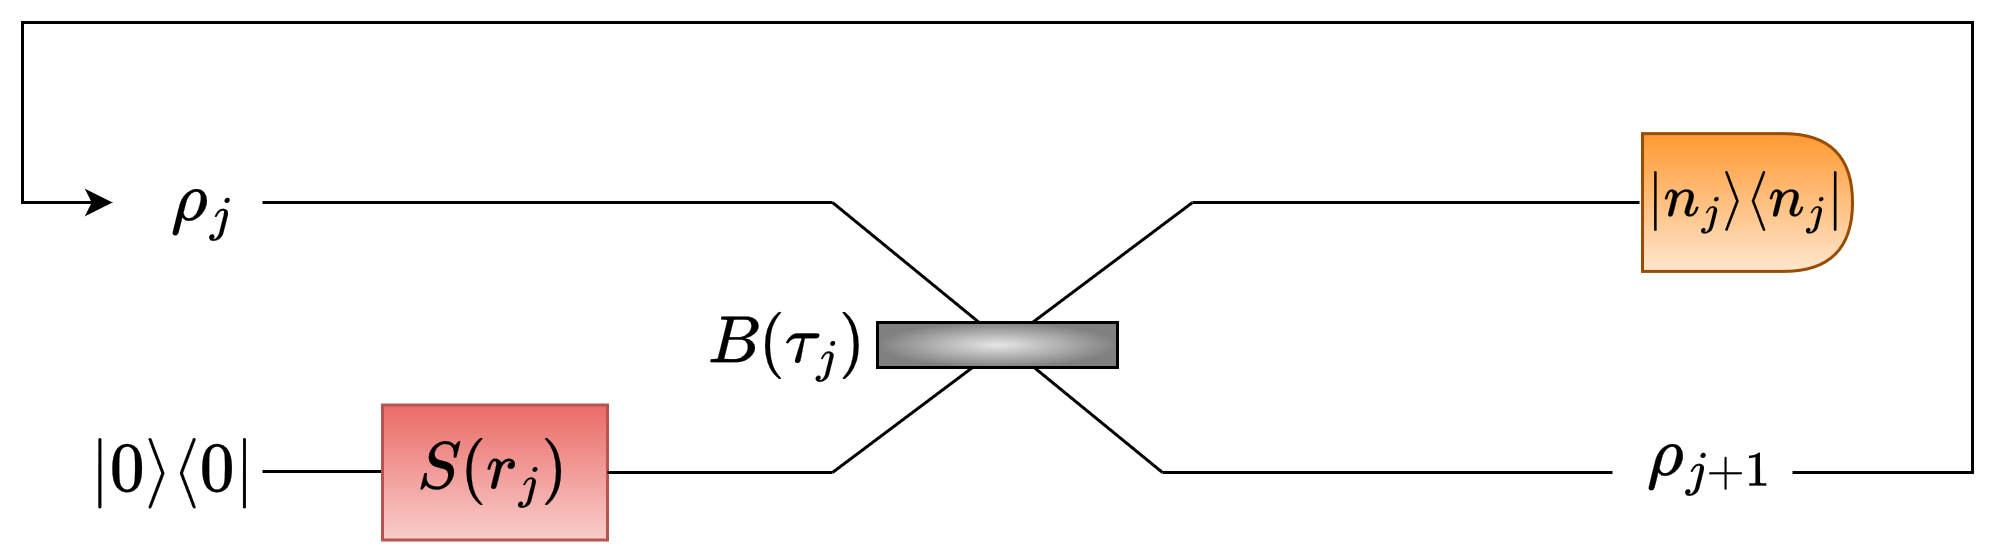

In [5]:
display(Image("img/loop_circ.png", width=600))

The circuit consists of two qumodes. The first qumode is an arbitrary input state $\rho_j$ and the second qumode is a vacuum state $\ket{0}\bra{0}$ which is transformed into a squeezed vacuum state by the squeezing operation $S(r_j)$. The two qumodes are then acted on by the beamsplitter operation $B(\tau_j)$ and afterwards the first qumode is measured in the photon number (Fock) basis. After this we take the non-measured qumode denoted as $\rho_{j+1}$ and feed it back into the circuit to repeat the process again. The hope was that we could train a reinforcement learning agent to learn what beamsplitter and squeezing parameters, $\tau_j$ and $r_j$ respectively, to select such that the output qumode $\rho_{j+1}$ would approximate a squeezed cat state over a finite number of iterations of the circuit. 

We found that the agent could in fact discover adaptive strategies for setting the beamsplitter and squeezing parameters such that it produced a squeezed cat state. Below we simulate an example of one such strategy. 

In [6]:
dim = 35

# Steps to create squeezed cat state
steps = [  {"tau": 0.335, "zeta": 1.38, "n":2 },
           {"tau": 0.948, "zeta": 1.38, "n":10 },
           {"tau": 0.709, "zeta": 1.38, "n":4 } ]


vac = ket_2_dm( fock_ket(dim, 0) )  # |0⟩⟨0|
rho = th.kron(vac, vac)  # ρ = |0⟩⟨0| ⊗ |0⟩⟨0|
I = th.eye(dim)  # I
U = th.kron(squeeze_recursive(dim, -1.38), I)  # U = S(ζ=-1.38) ⊗ I
rho = U @ rho @ th.conj(th.transpose(U, 0, 1))  # ρ =  UρU†

for i in range(len(steps)): 
    t_i = steps[i]["tau"] 
    zeta_i = steps[i]["zeta"] 
    n_i = steps[i]["n"] 
    
    if i > 0:
        rho = th.kron(dm_in, vac) # create the composite quantum system

    B = beamsplitter_recursive(dim, acos(t_i), 0)  # create the beamsplitter unitary B(θ=arccos(t_i), φ=0)
    S = th.kron(I, squeeze_recursive(dim, zeta_i))  # create the squeezing unitary S(ζ=zeta_i)
    
    rho = S @ rho @ th.conj(th.transpose(S, 0, 1))  # apply squeezing unitary to mode 2 
    rho = B @ rho @ th.conj(th.transpose(B, 0, 1))  # apply beamsplitter unitary to system 
    
    proj = ket_2_dm( fock_ket(dim, n_i) )  # create Fock state projector |n_i⟩⟨n_i| 
    rho = measure_pnr(rho, proj, I)  # apply projective measurement on mode 1 onto Fock state |n_i⟩
    
    dm_out = partial_trace(dim, rho, 1)  # compute partial trace over qumode 1 to recover reduced density matrix of qumode 2
    dm_in = dm_out

We will now show the Wigner function of the prepared quantum state after the 3 rounds/steps of our quantum circuit. The Wigner function is in fact that of a squeezed cat state. 

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

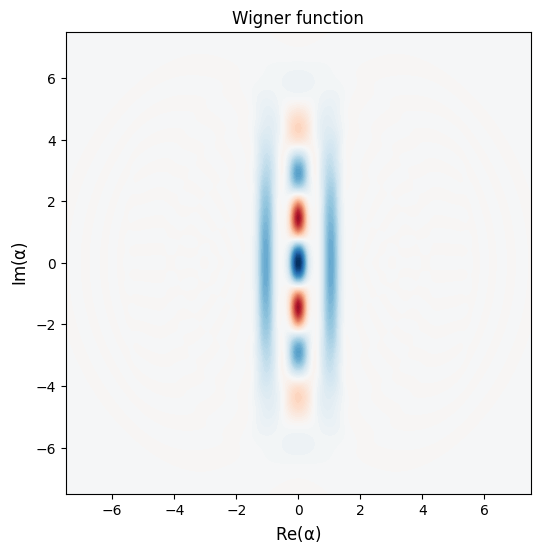

In [7]:
dm_np = dm_in.cpu().numpy()
plot_wigner(Qobj(dm_np))  # Use QuTiP wigner plotting function

In [8]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Thu Dec 12 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.2

torch: 2.2.1

